In [1]:
import pandas as pd
import os
import random
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, AveragePooling2D, Activation, BatchNormalization, MaxPool2D, GroupNormalization, Normalization
import matplotlib.pyplot as plt
import numpy as np

2024-03-11 14:54:03.635399: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-11 14:54:03.661937: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-11 14:54:03.661961: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-11 14:54:03.661973: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-11 14:54:03.667185: I tensorflow/core/platform/cpu_feature_g

In [2]:
images_metadata = pd.read_csv('HAM10000_metadata.csv')

In [3]:
images_metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
labels = pd.get_dummies(images_metadata.dx.to_frame(), dtype=int)
labels.head()

,dx_akiec,dx_bcc,dx_bkl,dx_df,dx_mel,dx_nv,dx_vasc
0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,1,0,0,0,0


In [13]:
image_labels = dict(zip(images_metadata.image_id, labels.values.tolist()))

In [14]:
all_files = os.listdir('dataset')

In [15]:
all_files_names = [os.path.splitext(i)[0] for i in all_files]

In [16]:
for image in list(image_labels.keys()):
    if image not in all_files_names:
        del image_labels[image]

In [19]:
counter = 0
for i in image_labels.values():
    if i == [0, 0, 0, 0, 0, 0, 1]:
        counter += 1
        
print(counter)

138


In [73]:
preliminary_data=list(zip(['dataset/' + image_name + '.jpg' for image_name in image_labels.keys()], image_labels.values()))

In [75]:
df_counter = 0 
for i in range(0, int(len(preliminary_data))):
    try:
        path, label = preliminary_data[i]
        if label == [0, 0, 0, 0, 0, 1, 0]:
            df_counter += 1
            del(preliminary_data[i])
    finally:
        continue

In [76]:
counter = 0
for i in preliminary_data:
    path, label = i
    if label == [0, 0, 0, 0, 0, 1, 0]:
        counter += 1
        
print(counter)

1583


In [77]:
random.shuffle(preliminary_data)

In [78]:
image_paths, labels=zip(*preliminary_data)

In [79]:
data = tf.data.Dataset.from_tensor_slices((list(image_paths), list(labels)))

In [80]:
IMG_SIZE = 227

def prepare_and_normalize_data(image_path, label):
    print(image_path)
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels = 3)
    
    return tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) / 255.0, label

In [81]:
data = data.map(prepare_and_normalize_data)

Tensor("args_0:0", shape=(), dtype=string)


In [82]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

def split_dataset(dataset):
    DATASET_SIZE = len(dataset)
    
    train_dataset = dataset.take(int(DATASET_SIZE * TRAIN_RATIO))
    val_dataset = dataset.skip(len(train_dataset)).take(int(DATASET_SIZE * VAL_RATIO))
    test_dataset = dataset.skip(len(train_dataset) + len(val_dataset)).take(int(DATASET_SIZE * TEST_RATIO))
    
    return train_dataset, val_dataset, test_dataset

In [83]:
train_dataset, val_dataset, test_dataset = split_dataset(data)

In [84]:
print(len(test_dataset), len(train_dataset))

473 3786


In [85]:
skin_conditions_list = [
      'actinic keratoses and intraepithelial carcinomae',
     'basal cell carcinoma',
     'benign keratosis-like lesions',
     'dermatofibroma',
     'melanocytic nevi',
     'pyogenic granulomas and hemorrhage',
     'melanoma'
    ]

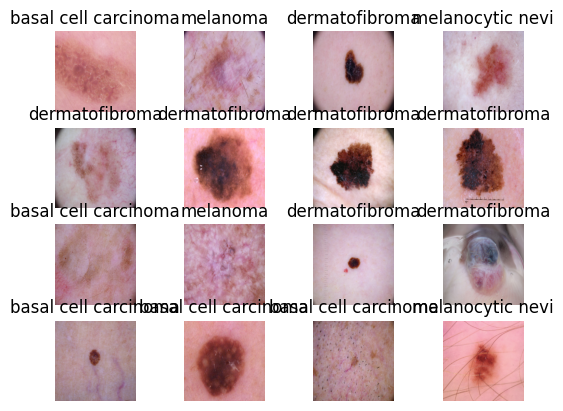

In [86]:
for i, (image, label) in enumerate(train_dataset.skip(21).take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    label_numerical = label.numpy()
    skin_condition_number = np.where(label_numerical == 1)[0][0]
    plt.title(skin_conditions_list[skin_condition_number - 1])
    plt.axis('off')

In [54]:
def le_net_model(input_shape=(32, 32, 3)):
        
    model = models.Sequential()
    model.add(Conv2D(6, 5, activation='tanh', input_shape=input_shape))
    model.add(AveragePooling2D(2))
    model.add(Activation('sigmoid'))
    model.add(Conv2D(16, 5, activation='tanh'))
    model.add(AveragePooling2D(2))
    model.add(Activation('sigmoid'))
    model.add(Conv2D(120, 5, activation='tanh'))
    model.add(Flatten())
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(7, activation='softmax'))
    
    return model

In [55]:
model = le_net_model()
model.summary()

NameError: name 'models' is not defined

In [87]:
def alex_net_model(input_shape = (227,227,3)):
    model = Sequential([
        Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')
    ])
    
    return model

In [88]:
model = alex_net_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_5 (Bat  (None, 55, 55, 96)        384       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 27, 27, 96)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_6 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                      

In [84]:
def my_model(input_shape = (227,227,3)):
    model = tf.keras.Sequential([
        Conv2D(30,(5,5),strides=(1,1),padding='valid',activation='relu',input_shape=input_shape),
        Conv2D(30,(3,3),strides=(1,1),padding='valid',activation='relu'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2,2),strides=None,padding='valid'),
        Conv2D(20,(3,3),strides=(1,1),padding='valid',activation='relu'),
        Conv2D(15,(3,3),strides=(1,1),padding='valid',activation='relu'),
        Conv2D(15,(3,3),strides=(1,1),padding='valid',activation='relu'),
        GroupNormalization(groups=3),
        MaxPool2D(pool_size=(2,2),strides=None,padding='valid'),
        Conv2D(10,(3,3),strides=(1,1),padding='valid',activation='relu'),
        Flatten(),
        Normalization(),
        Dense(256,activation='relu'),
        BatchNormalization(),
        Dropout(0.1),
        Dense(128,activation='relu'),
        Dense(7,activation='softmax')
    ])
    
    return model

In [85]:
model = my_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 223, 223, 30)      2280      
                                                                 
 conv2d_7 (Conv2D)           (None, 221, 221, 30)      8130      
                                                                 
 batch_normalization_2 (Bat  (None, 221, 221, 30)      120       
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 110, 110, 30)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 108, 108, 20)      5420      
                                                                 
 conv2d_9 (Conv2D)           (None, 106, 106, 15)     

In [64]:
# for LeNet model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [89]:
# for alexNet model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [86]:
# for my model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [99]:
history = model.fit(train_dataset.batch(64),epochs=100,validation_data=val_dataset.batch(64), shuffle=True)
#history = model.fit(x_train, y_train, batch_size=64, epochs=40, validation_data=(x_val, y_val))

Epoch 1/100
60/60 [==============================] - 5s 81ms/step - loss: 1.0471 - accuracy: 0.6080 - val_loss: 1.2156 - val_accuracy: 0.5243
Epoch 2/100
60/60 [==============================] - 5s 83ms/step - loss: 1.0606 - accuracy: 0.6101 - val_loss: 1.3816 - val_accuracy: 0.4820
Epoch 3/100
60/60 [==============================] - 5s 84ms/step - loss: 1.0683 - accuracy: 0.6101 - val_loss: 1.4237 - val_accuracy: 0.4588
Epoch 4/100
60/60 [==============================] - 5s 88ms/step - loss: 1.0367 - accuracy: 0.6173 - val_loss: 1.1776 - val_accuracy: 0.5433
Epoch 5/100
60/60 [==============================] - 5s 85ms/step - loss: 1.0349 - accuracy: 0.6160 - val_loss: 1.3219 - val_accuracy: 0.4292
Epoch 6/100
60/60 [==============================] - 5s 87ms/step - loss: 1.0235 - accuracy: 0.6175 - val_loss: 1.1321 - val_accuracy: 0.5729
Epoch 7/100
60/60 [==============================] - 5s 81ms/step - loss: 1.0156 - accuracy: 0.6300 - val_loss: 1.1132 - val_accuracy: 0.5751
Epoch 

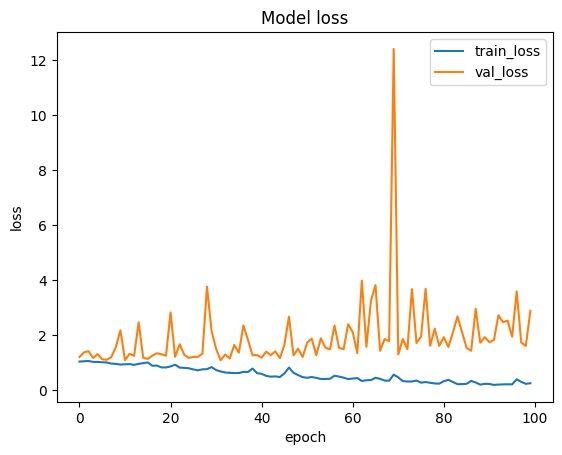

In [100]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])

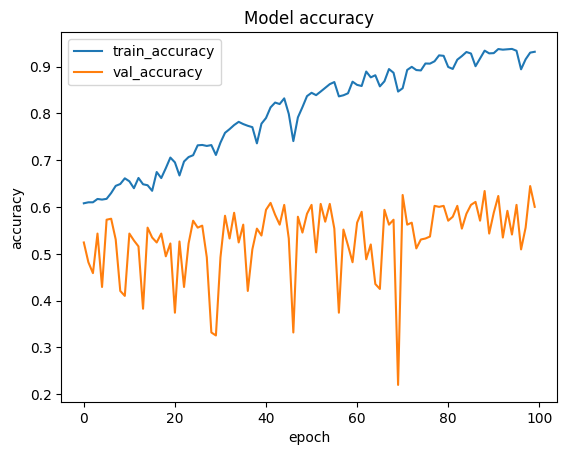

In [101]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])

In [112]:
model.save("alex_v1")

INFO:tensorflow:Assets written to: alex_v1/assets


INFO:tensorflow:Assets written to: alex_v1/assets


In [41]:
from tensorflow.keras import models

In [42]:
reloaded_model = models.load_model('alex_v1')

In [103]:
test_loss, test_acc = model.evaluate(test_dataset.batch(60))
print(f"Test accuracy: {test_acc*100:.3f}")


8/8 [==============================] - 2s 27ms/step - loss: 2.8557 - accuracy: 0.5962
Test accuracy: 59.619


In [109]:
import cv2

In [111]:
test_image = cv2.resize(cv2.imread("df.jpeg"),  (IMG_SIZE,IMG_SIZE))

test_image = np.array(test_image).reshape( -1, IMG_SIZE, IMG_SIZE, 3)

prediction = model.predict(test_image)
print(prediction)

1/1 [==============================] - 0s 13ms/step
[[0. 0. 0. 0. 0. 1. 0.]]


In [106]:
predictions=model.predict(test_dataset.skip(100).batch(64))


6/6 [==============================] - 2s 63ms/step


In [107]:
predictions

array([[1.3924943e-15, 1.0000000e+00, 9.9245643e-16, ..., 9.5306394e-17,
        1.4027368e-14, 1.1347224e-16],
       [3.1631087e-09, 8.7071362e-07, 1.7191671e-05, ..., 6.8795875e-05,
        6.3745189e-05, 9.9984932e-01],
       [1.2512745e-02, 5.3439010e-02, 8.5233665e-01, ..., 4.0468093e-02,
        3.5680823e-02, 1.0217480e-04],
       ...,
       [5.9584540e-01, 1.5873976e-01, 1.4134036e-01, ..., 2.4127513e-02,
        2.8765673e-02, 4.3375259e-03],
       [3.0721849e-01, 5.0587839e-01, 6.0579080e-02, ..., 9.0963766e-03,
        1.7092342e-02, 1.1936702e-03],
       [4.1541066e-03, 1.1303793e-03, 6.2490967e-03, ..., 9.7059107e-01,
        1.7533951e-02, 5.6803681e-05]], dtype=float32)